# Registration

Correct for rigid/non-rigid movement

- Apply the nonrigid motion correction (NoRMCorre) algorithm for motion correction.
- View pre/most correction movie
- Use quality metrics to evaluate registration quality

In [35]:
# Imports

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import pandas as pd

import mesmerize_core as mc
import numpy as np
import tifffile
from matplotlib import pyplot as plt
import fastplotlib as fpl

from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
import lbm_caiman_python as lcp

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (12, 8),
    'ytick.major.left': True,
})
jet = mpl.colormaps['jet']
jet.set_bad(color='k')

pd.options.display.max_colwidth = 120

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### (optional): View hardware information

In [236]:
!pip install cloudmesh-cmd5
!cms help # dont forget to call it after the install as it sets some defaults
!cms sysinfo

*** No help on # dont forget to call it after the install as it sets some defaults
+------------------+----------------------------------------------------------------------------------------------+
| Attribute        | Value                                                                                        |
+------------------+----------------------------------------------------------------------------------------------+
| cpu              |                                                                                              |
| cpu_cores        | 24                                                                                           |
| cpu_count        | 32                                                                                           |
| cpu_threads      | 32                                                                                           |
| date             | 2024-12-09 17:10:54.386633                                                          

### Data path setup

We set 2 path variables:

1. `data_path` : input, path where you saved the output from the assembly step
2. `batch_path` : results, can be anywhere you please, must end in .pickle

```{note}
This notebook assumes you saved scans as TIFF with `join_contiguous=True` so filenames are `plane_N.tiff`
The process for `join_contiguous=False` is the same, but with the roi attached to the filename `plane_N_roi_M`.
```
To simplify data management, we put our batch_path (which stores results) in the same directory as our raw data.

In [2]:
parent_path = Path().home() / "caiman_data"
data_path = parent_path / 'out'  # where the output files from the assembly step are located
batch_path = data_path / 'batch_v2.pickle'

In [3]:
tiff_files = [x for x in Path(data_path).glob('*.tif*')]
tiff_files

[WindowsPath('C:/Users/RBO/caiman_data/out/plane_1.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_10.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_11.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_12.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_13.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_14.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_15.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_16.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_17.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_18.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_19.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_2.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_20.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_21.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_22.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_23.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out

### Load a data file to examine

In [4]:
file = tiff_files[1]
data = tifffile.imread(file)
data.shape

(1730, 600, 576)

## View metadata

`lcp.get_metadata(filepath)` works on raw scanimage files and files processed through `lcp.save_as()`

In [5]:
metadata = lcp.get_metadata(file)
metadata

{'image_height': 2478,
 'image_width': 145,
 'num_pages': 51900,
 'ndim': 3,
 'dtype': 'uint16',
 'size': 18648189000,
 'shape': [51900, 2478, 145],
 'num_planes': 30,
 'num_rois': 4,
 'num_frames': 1730.0,
 'frame_rate': 9.60806,
 'fov': [150, 600],
 'pixel_resolution': [1.04, 1.0],
 'roi_width_px': 144,
 'roi_height_px': 600,
 'sample_format': 'int16',
 'num_lines_between_scanfields': 24,
 'center_xy': [-1.428571429, 0],
 'line_period': 4.15652e-05,
 'size_xy': [0.9523809524, 3.80952381],
 'objective_resolution': 157.5}

In [6]:
dxy = metadata['pixel_resolution']
print(f"Pixel resolution: {dxy[0]} um/px, {dxy[1]} um/px")

Pixel resolution: 1.04 um/px, 1.0 um/px


In [7]:
# note this is only for a single ROI
fov = metadata['fov']
print(f"Field of View: {fov[0]}px, {fov[1]}px")

Field of View: 150px, 600px


In [8]:
fr = metadata['frame_rate']
print(f"Frame rate: {fr} Hz")

Frame rate: 9.60806 Hz


# Registration parameters

| Parameter               | Description                                                                                     | Value/Default                  |
|-------------------------|-------------------------------------------------------------------------------------------------|--------------------------------|
| `dxy`                  | Spatial resolution (pixel size in micrometers).                                                 | `dxy` (from metadata)           |
| `fr`                   | Frame rate of the video (frames per second).                                                    | `fr` (from metadata)            |
| `max_shifts`           | Maximum allowed rigid shift in pixels for motion correction.                                     | `(int(10/dxy), int(10/dxy))`   |
| `strides`              | Size of patches for motion correction.                                                          | `[48, 48]`                     |
| `overlaps`             | Overlap between patches for motion correction.                                                  | `[24, 24]`                     |
| `max_deviation_rigid`  | Maximum allowed deviation for patches relative to rigid shifts.                                  | `3`                            |
| `border_nan`           | How to handle border values during motion correction.                                            | `'copy'`                       |
| `pw_rigid`             | Flag indicating whether to perform piecewise rigid motion correction.                            | `False`                        |
| `gSig_filt`            | Size of the Gaussian filter for smoothing the motion correction process.                         | `(3, 3)`                       |
| `shifts_opencv`        | Flag to use bicubic interpolation for motion correction.                                         | `True`                         |

The parameters are passed **directly** to `caiman`, this means you need to use the same exact names for the parameters and you can use all the parameters that you can use with `caiman` - because it's just passing them to `caiman`.

The parameters dict for a mesmerize batch item must have the following structure. Put all the parameters in a dict under a key called **main**. The **main** dict is then fed directly to `caiman`.

```python
{"main": {... params directly passed to caiman}}
```

## Using metadata to assign parameter values

```{important}
The goal here is to get an approximate neuron size in microns.
This value is used as the basis of the `patch` and `max_shifts` parameters.
```

`plot_data_with_scalebars` will give you 3 images, at 5, 10 and 20 um.

You can use any summary images:

```python
# a single frame
plot_with_scalebars(data[0, :, :], np.mean(dxy))           

# mean projection image
plot_with_scalebars(np.mean(data, axis=0), np.mean(dxy))  

# maximum projection image
plot_with_scalebars(np.max(data, axis=0), np.mean(dxy))    
```

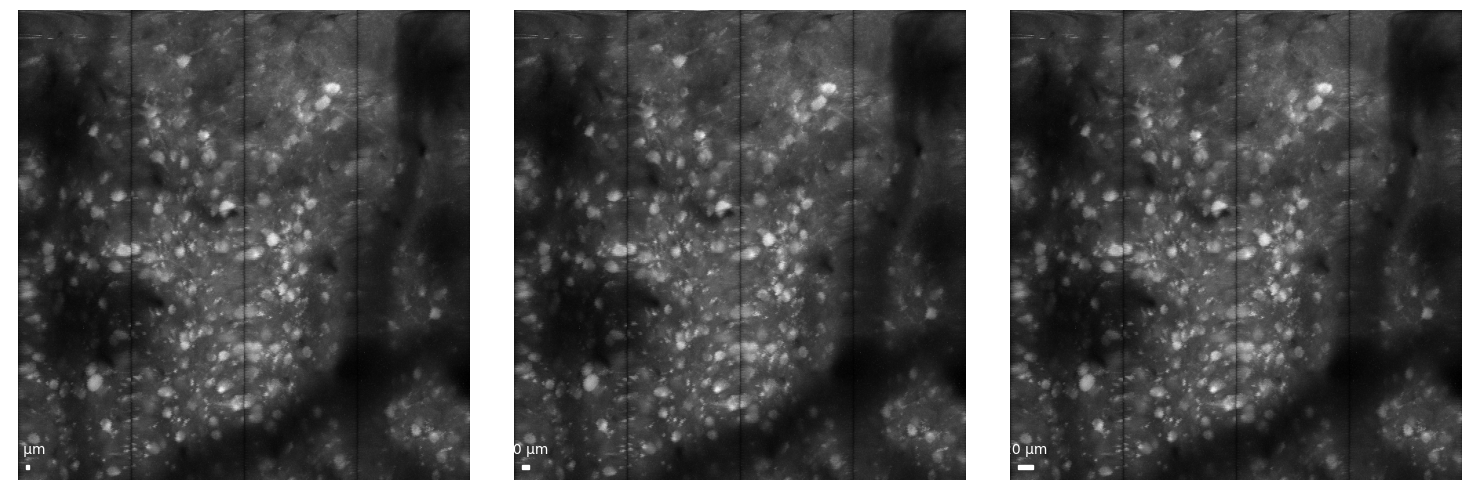

In [11]:
from lbm_caiman_python import plot_with_scalebars

# plot_with_scalebars(data[0, :, :], np.mean(dxy))
plot_with_scalebars(np.max(data, axis=0), np.mean(dxy))

## Scaling patches relative to neuron size

The `generate_patch_view` function divides the image into patches the same way CaImAn will do internally.

Increasing / decreasing the `target_patch_size` and `overlap_fraction` parameters to examine the effect of different stride/overlap values displayed in the title. 

```{tip}
We want each patch to have "landmarks" (neurons) to use for alignment, so we want at least a few full neurons for each patch.

For this reason, we use the `neuron_size` * `scale_factor` as our `target_patch_size`.

We want to **avoid** neurons occupying the inner regions of multiple neighboring patches.
```

In [12]:
neuron_size = 15    # in micron

# - value of 1 makes patches ~neuron sized
# - value of 2 makes patches ~2x neuron sized
# - the larger your neurons, the larger you want to make this number
scale_factor = 3 # must be > 0

overlap_fraction = 0.3  # 30% of the patch size will be overlap

In [13]:
from lbm_caiman_python import generate_patch_view

target_patch_size=neuron_size*scale_factor    

# this function assumes a square pixel resolution, so take the mean
fig, ax, stride_px, overlap_px = generate_patch_view(np.max(data, axis=0), pixel_resolution=np.mean(dxy), target_patch_size=target_patch_size, overlap_fraction=overlap_fraction)
plt.show()

In [14]:
print(f'stride : {stride_px}px\noverlap: {overlap_px}px')

stride : 44px
overlap: 13px


In [15]:
# From the above image, we get our overlaps/strides parameters
# This is in *pixels*, not microns
strides = [stride_px, stride_px]
overlaps = [overlap_px, overlap_px]

## Create the parameters we pass to CaImAn

The above patch view looks good, so we use those values in our parameters dictionary.

You *can* also include segmentation parameters in this dictionary if you wish. This is *not recommmended* as several parameters share similar names yet perform different actions. i.e:
-  `stride` and `gSig_filt` parameters are for registration
-  `strides` for `gSig` are parameters for segmentation

```{note}
We want our parameters to physically make sense. 

`max_shifts` controls the maximum number of pixels that each individual patch can be shifted.

We don't want to shift any patches more than a full overlap which would introduce artifacts into neighboring patches.
```

In [16]:
max_shifts = (int(overlaps[0] / 2), int(overlaps[0] / 2))   # maximum allowed rigid shift in pixels 
max_deviation_rigid = 3               # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = True                       # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True                  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'                   # replicate values along the boundary (if True, fill in with NaN)

mcorr_params = {
    'main':  # this key is necessary for specifying that these are the "main" params for the algorithm
    {
        'dxy': dxy,
        'fr': fr,
        'max_shifts': max_shifts, # make sure its a tuple/list of integers
        'strides': strides,
        'overlaps': overlaps,
        'max_deviation_rigid': 3,
        'border_nan':border_nan,
        'pw_rigid': pw_rigid,
        'gSig_filt': (3, 3),
    },
}

### Run registration with `mesmerize-core`

See the mesmerize-core [utility docs](https://mesmerize-core.readthedocs.io/en/latest/api/functions.html) for more information on batch creation.


### Create or load a batch set

```{warning}
In the below if-else clause, be careful if you expect a batch to exist, a typo can be deceiving!
```

In [ ]:
# Create or load a batch results file
# To overwrite:
# df = mc.create_batch(batch_path, remove_existing=True)

if not batch_path.exists():
    print(f'creating batch: {batch_path}')
    df = mc.create_batch(batch_path)
else:
    df = mc.load_batch(batch_path)

# tell mesmerize where the raw data is
mc.set_parent_raw_data_path(data_path)
df

### Add an item to the batch

A "batch item" consists of:
* algorithm to run, `algo` 
    - currently: mcorr, cnmf, cnmfe
* input movie to run the algorithm on, `input_movie_path`
    - can be string or dataframe row
* parameters for the specified algorithm, `params`
* a name for you to keep track of things `item_name`
    - can be anything

In [17]:
df.caiman.add_item(
    algo='mcorr',
    input_movie_path=file,
    params=mcorr_params,
    item_name='mcorr',
)
df

algo item_name input_movie_path  \
0  mcorr     mcorr    plane_10.tiff   

                                                                                                                    params  \
0  {'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (6, 6), 'strides': (44, 44), 'overlaps': (13, 13), 'max_d...   

  outputs           added_time ran_time algo_duration comments  \
0    None  2024-12-09T17:18:15     None          None     None   

                                   uuid  
0  790b1747-10dd-498f-a11b-dbc267b5c1fd

## First registration run

```{note}
On Linux & Mac it will run in subprocess but on Windows it will run in the local kernel.
For this reason, on windows you need to reload the dataframe:
```
```python
df=df.caiman.reload_from_disk()
df
```

If you ever get errors like 

```python
TypeError: NoneType is not subscriptable
```
**This likely means you need to reload the dataframe**.

```{warning}
On windows, `df.iloc[i].caiman.run()` will sometimes stall if you run additional cells before it completes.
```

In [18]:
df.iloc[0].caiman.run()

Running 790b1747-10dd-498f-a11b-dbc267b5c1fd with local backend
starting mc


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


In [19]:
df=df.caiman.reload_from_disk()
df

algo item_name input_movie_path  \
0  mcorr     mcorr    plane_10.tiff   

                                                                                                                    params  \
0  {'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (6, 6), 'strides': (44, 44), 'overlaps': (13, 13), 'max_d...   

                                                                                                                   outputs  \
0  {'mean-projection-path': 790b1747-10dd-498f-a11b-dbc267b5c1fd\790b1747-10dd-498f-a11b-dbc267b5c1fd_mean_projection.n...   

            added_time             ran_time algo_duration comments  \
0  2024-12-09T17:18:15  2024-12-09T17:19:47     79.33 sec     None   

                                   uuid  
0  790b1747-10dd-498f-a11b-dbc267b5c1fd

### Check for errors in outputs

In the table header **outputs**, you should see 

```python
{'mean-projection-path': ...}
```
If you see instead:

```python
{'success': False, ...}
```

Run the below cell to evaluate the error message.

In [20]:
import pprint
pprint.pprint(df.iloc[0].outputs["traceback"])

None


## Evaluate motion correction outputs with `mesmerize-core` API 

mesmerize-core offers an easy [API](https://mesmerize-core.readthedocs.io/en/latest/api/mcorr.html) to retrieve results from the batch dataframe.

In [18]:
# get the motion corrected movie memmap
mcorr_movie = df.iloc[0].mcorr.get_output()

# the input movie, note that we use `.caiman` here instead of `.mcorr`
input_movie = df.iloc[0].caiman.get_input_movie()

### Side-by-side with `fastplotlib`

Its helpful to zoom into specific locations of your images to see improvements.

RFBOutputContext()

JupyterWgpuCanvas(css_height='560px', css_width='900px')
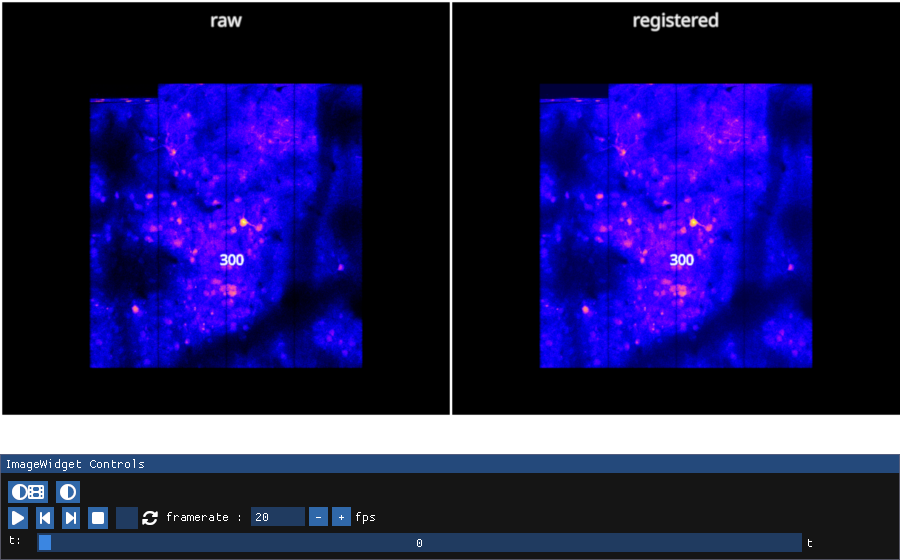

In [19]:
mcorr_iw = fpl.ImageWidget(
    data=[input_movie, mcorr_movie],
    names=['raw', 'registered'],
    cmap="gnuplot2",
    window_funcs={"t": (np.mean, 3)}, # window functions, can change to np.max, np.std, anything that operates on a timeseries
    figure_kwargs={"size": (900, 560)},
    histogram_widget=False, # helps keep plots close together
)
mcorr_iw.show()

In [20]:
mcorr_iw.close()

# Define parameter varients

If you still see non-rigid motion in your movie, we can try increasing the scale_factor to increase our patch-size or decrease it. 

More than likely you will want to decrease the scale factor to process more patches.

The patched graphs displayed show you what patches each of your movie will use.

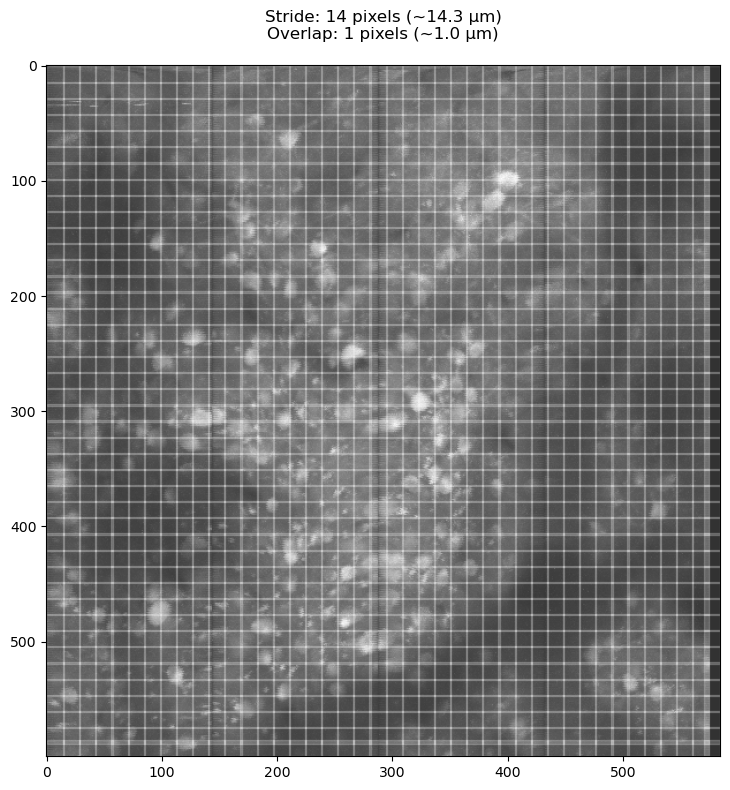

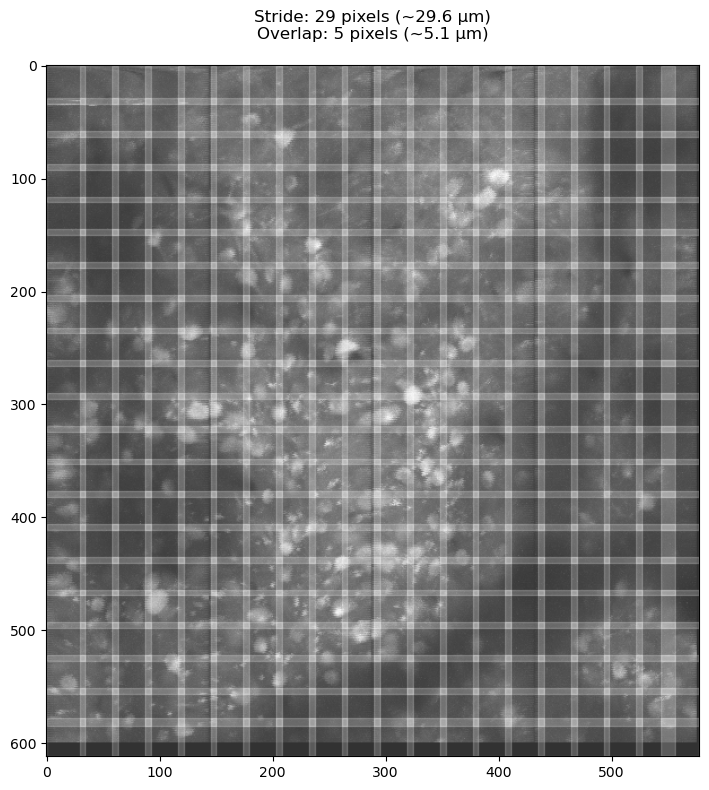

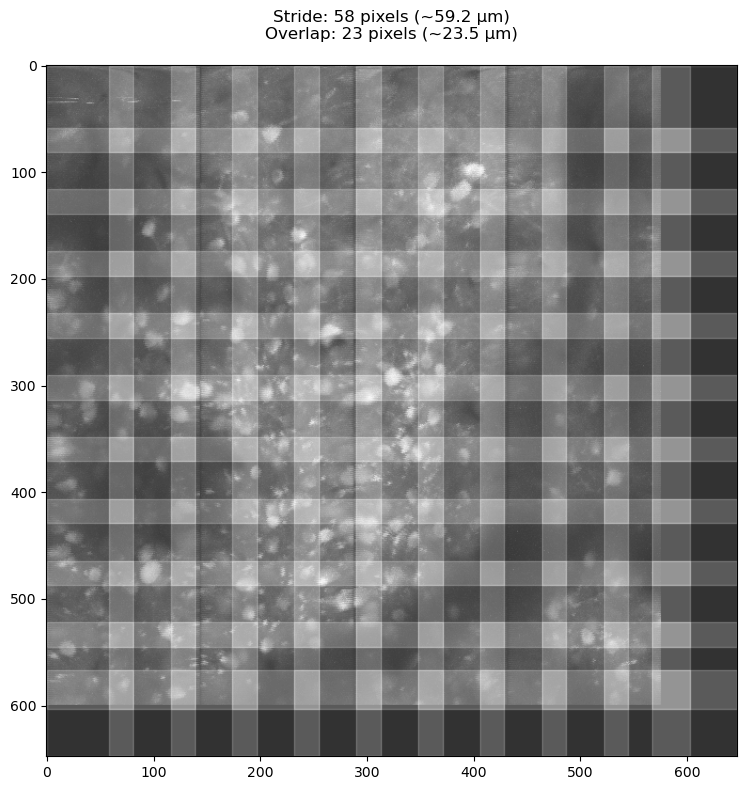

In [22]:
from copy import deepcopy

for scale in (1, 2, 4): # we started with a scale of 3
    target_patch_size=neuron_size*scale    
    overlap_fraction = .3 # keep overlap to 30% of patch size
    
    _, _, stride_px, overlap_px = generate_patch_view(np.max(data, axis=0), pixel_resolution=np.mean(dxy), target_patch_size=target_patch_size, overlap_fraction=overlap_fraction)
    
    # deep copy is the safest way to copy dicts
    new_params = deepcopy(mcorr_params)

    new_shift = int(np.ceil(overlap_px / 2))
    new_stride = int(np.ceil(stride_px))
    new_overlap = int(np.ceil(overlap_px))

    new_params["main"]["max_shifts"] = (new_shift, new_shift)
    new_params["main"]["strides"] = (new_stride, new_stride)
    new_params["main"]["overlaps"] = (new_overlap, new_overlap)

    df.caiman.add_item(
        algo='mcorr',
        input_movie_path=file,
        params=new_params,
        item_name='mcorr',  # filename of the movie, but can be anything
    )

```{tip}
We can use the `caiman.get_params_diffs()` to see the unique parameters between rows with the same `item_name`.

This shows the parameters that differ between our batch items.
```

In [21]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])
diffs

strides  overlaps max_shifts
0  (44, 44)  (13, 13)     (6, 6)
1  (14, 14)    (1, 1)     (1, 1)
2  (29, 29)    (5, 5)     (3, 3)
3  (58, 58)  (23, 23)   (12, 12)

#### (Optional) Use your own grid-search values.

For example:

``` python
from copy import deepcopy

for shifts in [2,32]:
    for strides in [12,64]:
        overlaps = int(strides / 2)
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(mcorr_params)

        # assign the "max_shifts"
        new_params["main"]["pw_rigid"] = True
        new_params["main"]["max_shifts"] = (shifts, shifts)
        new_params["main"]["strides"] = (strides, strides)
        new_params["main"]["overlaps"] = (overlaps, overlaps)

        df.caiman.add_item(
            algo='mcorr',
            input_movie_path=file,
            params=new_params,
            item_name='mcorr',  # filename of the movie, but can be anything
        )

df.caiman.reload_from_disk()
```

### Use the varients to organize results to run multiple batch items.

`df.iterrows()` iterates through rows and returns the numerical index and row for each iteration

In [25]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

Running 8c1d98d9-57a1-414f-a046-b678cc7a8410 with local backend
starting mc


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 5c844e2a-924b-469f-87b4-fd81db666020 with local backend
starting mc


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running d7a55f83-6d9d-40e1-9e43-25a39a7a5c69 with local backend
starting mc


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


In [ ]:
# make sure everything works properly
# check for outputs {'success': False, ...
df = df.caiman.reload_from_disk()
df

# Calculate registration metrics

The first cell iterates over our batch dataframe and collects several metrics to help distinguish which parameter varients lead to the best registration results.

In [25]:
import pandas as pd
from caiman.motion_correction import compute_metrics_motion_correction

# downsampling in time to help with memory efficiency and can make visualizing movement easier
downsample_factor = 2

subplot_names = []
shifts = []
movies = [df.iloc[0].caiman.get_input_movie()[::downsample_factor, ...]]
subplot_names.append("raw")

# registration metrics parameters
winsize = 100
swap_dim = False  # True if your data is X,Y,T, which it should **not** be
resize_fact_flow = 0.2 
final_size = data.shape[1:]

metrics_list = []

# get the param diffs to set plot titles
param_diffs = df.caiman.get_params_diffs("mcorr", item_name=df.iloc[0]["item_name"])

print('Computing registration metrics and combining results. This can take time.')
# add all the mcorr outputs to the list
for i, row in df.iterrows():

    if row.algo != 'mcorr':
        continue
        
    input_path = row.mcorr.get_output_path()


    print(f'Computing registration metrics for row {i}.')
    template, correlations, flows, norms, crispness = compute_metrics_motion_correction(
        input_path, final_size[0], final_size[1], swap_dim=swap_dim
    )

    # subplot title to show dataframe index
    subplot_names.append(f"ix {i}: max_sh: {max_shifts}, str: {strides}, ove: {overlaps}")
    movies.append(row.mcorr.get_output()[::downsample_factor, ...])
    
    max_shifts = param_diffs.iloc[i]["max_shifts"][0]
    strides = param_diffs.iloc[i]["strides"][0]
    overlaps = param_diffs.iloc[i]["overlaps"][0]
    metrics_list.append({
        'index': i,
        'template': template,
        'correlations': correlations,
        'flows': flows,
        'norms': norms,
        'crispness': crispness
    })

# store our results into a nice dataframe for display / access
metrics_df = pd.DataFrame(metrics_list)

computing registration metrics... this can take a significant amount of time.
computing registration metrics... this can take a significant amount of time.
computing registration metrics... this can take a significant amount of time.
computing registration metrics... this can take a significant amount of time.


# Correlation with Mean Image

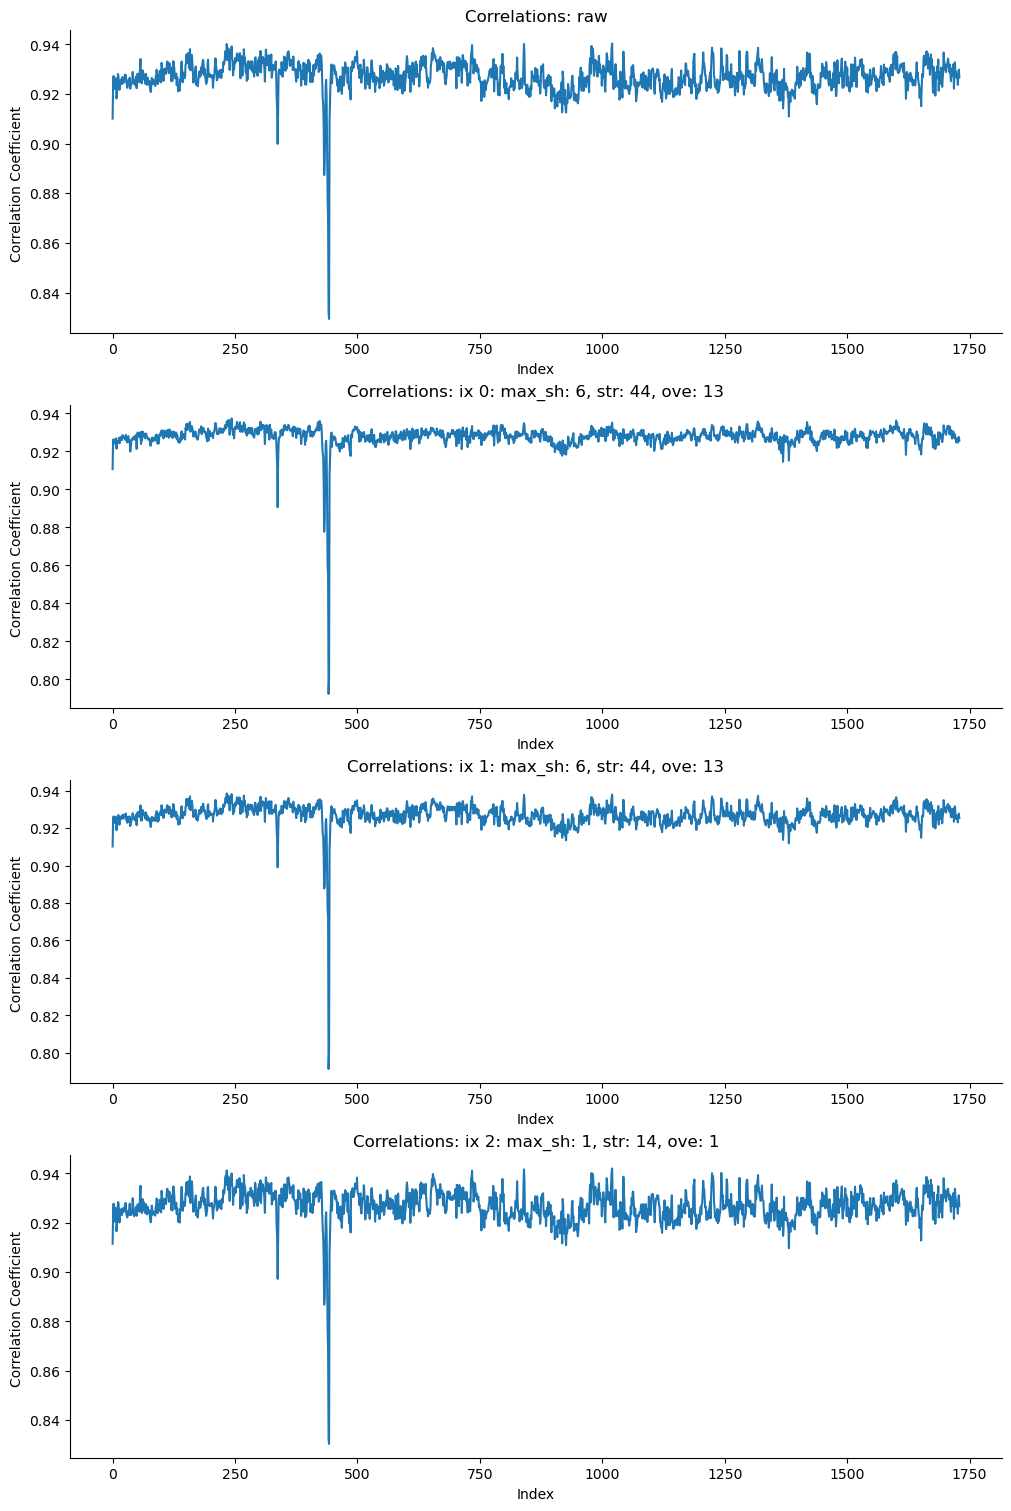

In [38]:
import matplotlib.pyplot as plt

# get the total number of rows in the dataframe
num_graphs = len(metrics_df)

# create a figure and axes for the subplots
fig, axes = plt.subplots(num_graphs, 1, figsize=(10, 15), constrained_layout=True)

# iterate over each row in the dataframe
for i, (idx, row) in enumerate(metrics_df.iterrows()):
    ax = axes[i] if num_graphs > 1 else axes  # handle case where num_graphs == 1
    ax.plot(row['correlations'])
    ax.set_title(f'Correlations: {subplot_names[idx]}')  # use the index as part of the name
    ax.set_xlabel('Frame')
    ax.set_ylabel('Correlation Coefficient')

# display the plot
plt.show()

## Optical Flow + Crispness of Mean Image

The better your registration, the **less blurry** your mean image should be. Crispness gives a quantitative measure of that blurryness.

71.19248+/-37.29028 ; 87338.31 ; 23.820064458654514
89.210144+/-57.70227 ; 86577.33 ; 23.362327283659955
68.52898+/-37.97284 ; 87442.625 ; 23.74050974669385
66.81271+/-32.996044 ; 87028.19 ; 23.866299322620815


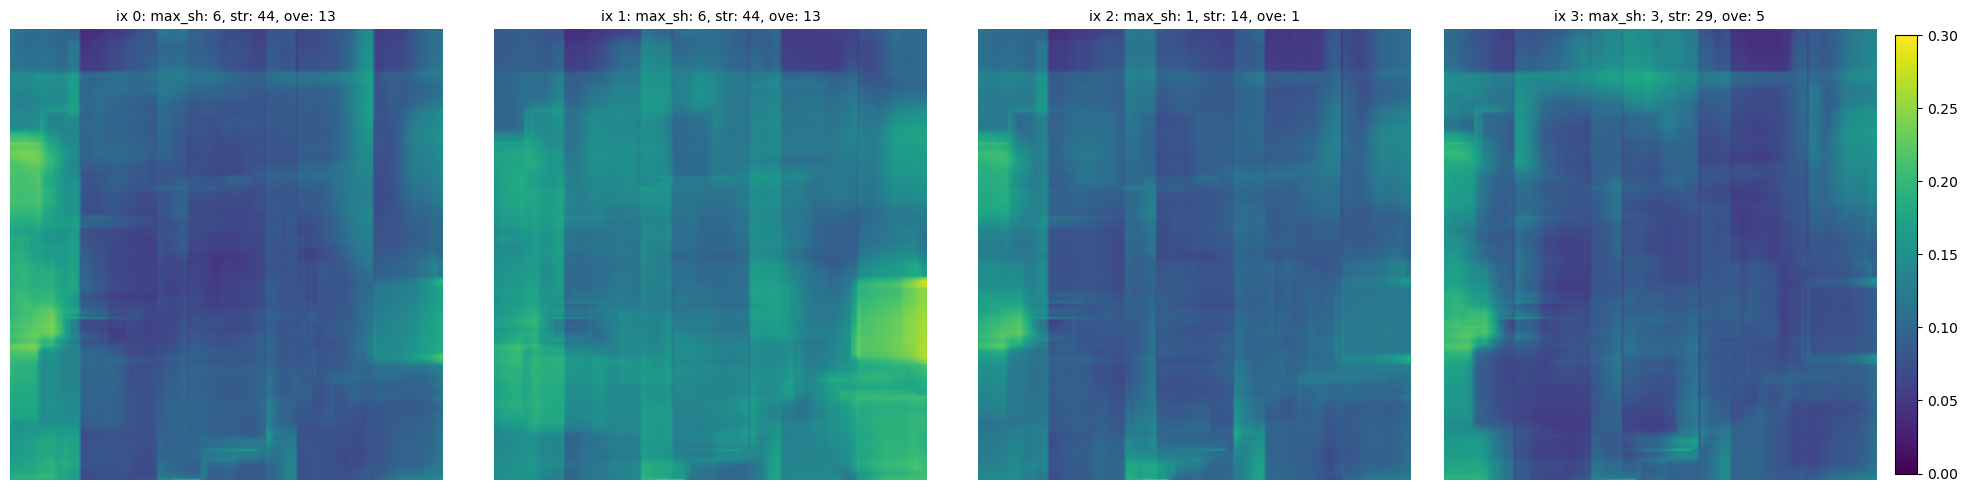

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import caiman as cm
from pathlib import Path

# generate the list of files dynamically from the dataframe
fls = []
for i in range(len(df)):
    mmap_path = Path(df.iloc[i].mcorr.get_output_path())
    parent_dir = mmap_path.parent  # extract parent directory
    base_filename = mmap_path.name  # keep the full filename intact
    metrics_filename = base_filename.replace('.mmap', '_metrics.npz')  # replace .mmap with _metrics.npz
    full_metrics_path = parent_dir / metrics_filename  # full path to the .npz file
    fls.append({'metrics_path': full_metrics_path, 'index': i})  # store paths and index

# create a horizontal row of subplots for optical flow
plt.figure(figsize=(20, 5))  # adjust the width for better visibility of all graphs

# iterate through each row in the dataframe
for cnt, paths in enumerate(fls):
    metrics_path = paths['metrics_path']
    index = paths['index']  # get the index of the dataframe

    with np.load(metrics_path) as ld:
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))

        # Plot only the Optical Flow
        plt.subplot(1, len(fls), cnt + 1)  # single row, multiple columns
        flows = ld['flows']
        plt.imshow(np.mean(np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), axis=0), vmin=0, vmax=0.3)
        plt.title(f'{subplot_names[cnt + 1]}', fontsize=10)  # use dataframe index as title
        plt.axis('off')
        
plt.colorbar(fraction=0.046, pad=0.04)  # add a small colorbar
plt.tight_layout()
plt.show()


In [54]:
subplot_names

['raw',
 'ix 0: max_sh: 6, str: 44, ove: 13',
 'ix 1: max_sh: 6, str: 44, ove: 13',
 'ix 2: max_sh: 1, str: 14, ove: 1',
 'ix 3: max_sh: 3, str: 29, ove: 5']

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import caiman as cm
from pathlib import Path

# generate the list of files dynamically from the dataframe
fls = []
for i in range(len(df)):
    mmap_path = Path(df.iloc[i].mcorr.get_output_path())
    parent_dir = mmap_path.parent  # extract parent directory
    base_filename = mmap_path.name  # keep the full filename intact
    metrics_filename = base_filename.replace('.mmap', '_metrics.npz')  # replace .mmap with _metrics.npz
    full_metrics_path = parent_dir / metrics_filename  # full path to the .npz file
    fls.append({'metrics_path': full_metrics_path, 'index': i})  # store paths and index

# Create a figure and subplots for the optical flow
fig, axes = plt.subplots(3, len(fls), figsize=(20, 10), gridspec_kw={'height_ratios': [0.2, 0.8, 0.1]})

# Add the main title
plt.suptitle('Optical Flow', fontweight='bold', fontsize=16)

# iterate through each row in the dataframe
flow_images = []  # store flow images for colorbar
for cnt, paths in enumerate(fls):
    metrics_path = paths['metrics_path']
    index = paths['index']  # get the index of the dataframe

    with np.load(metrics_path) as ld:
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))

        # 1st Row: Title using subplot_names
        axes[0, cnt].set_title(f'{subplot_names[cnt + 1]}', fontweight='bold', fontsize=12)  # first subplot_name is raw
        axes[0, cnt].axis('off')

        # 2nd Row: Plot only the Optical Flow
        flows = ld['flows']
        flow_img = np.mean(np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), axis=0)
        im = axes[1, cnt].imshow(flow_img, vmin=0, vmax=0.3)
        flow_images.append(flow_img)  # store for colorbar
        axes[1, cnt].axis('off')

        # 3rd Row: Statistics (mean, std, smoothness, smoothness_corr)
        mean_norm = np.mean(ld['norms'])
        std_norm = np.std(ld['norms'])
        smoothness = ld['smoothness']
        smoothness_corr = ld['smoothness_corr']
        
        stat_text = f'{mean_norm:.2f} ± {std_norm:.2f}\n{smoothness:.2f}\n{smoothness_corr:.2f}'
        axes[2, cnt].text(0.5, 0.5, stat_text, ha='center', va='center', fontsize=10)
        axes[2, cnt].axis('off')

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=0, vmax=0.3)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Flow Magnitude', fontsize=12)

plt.show()


71.19248+/-37.29028 ; 87338.31 ; 23.820064458654514
89.210144+/-57.70227 ; 86577.33 ; 23.362327283659955
68.52898+/-37.97284 ; 87442.625 ; 23.74050974669385
66.81271+/-32.996044 ; 87028.19 ; 23.866299322620815


## Difference of Gaussian Blur

In [81]:
from ipywidgets import IntSlider, VBox, HBox, FloatSlider
from caiman.motion_correction import high_pass_filter_space

movie_A = movies[0] # raw
movie_B = movies[1] # first registration run

blur_A_slider = IntSlider(value=1, min=1, max=33, step=1,  description="high-pass-filter A (σ)")
blur_B_slider = IntSlider(value=2, min=1, max=33, step=1,  description="high-pass-filter B (σ)")

def apply_filter(frame):
    # read slider value
    blur_A = (blur_A_slider.value, blur_A_slider.value)
    blur_B = (blur_B_slider.value, blur_B_slider.value)

    # this frame now has 2 images, with different sigma values
    blured_img_A = high_pass_filter_space(frame, blur_A)
    blured_img_B = high_pass_filter_space(frame, blur_B)

    diff = blured_img_A - blured_img_B
    return diff

def diff_frame(frame):
    # current time index
    # grab the current data at this index 
    fa =  iw_gs.managed_graphics[1].data[:]
    fb =  iw_gs.managed_graphics[0].data[:]
    
    diff = fa - fb
    
    iw_gs.managed_graphics[-1].data[:] = diff
    # iw_gs.reset_vmin_vmax()
    return diff
    
funcs = {
    0: apply_filter,
    1: apply_filter,
    2: diff_frame
}

# input movie will be shown on left, filtered on right
iw_gs = fpl.ImageWidget(
    data=[movie_A, movie_B, movie_A[0, ...]],
    frame_apply=funcs,
    names=[f"", f"filtered", "Difference"],
    figure_kwargs={"size": (1200, 600), "shape": (1, 3)},
    cmap="gray",
)

iw_gs.figure["filtered"].set_title(f"filtered σ=({blur_A_slider.value},{blur_B_slider.value})")

def force_update(*args):
    # forces the images to update when the gSig_filt slider is moved
    iw_gs.current_index = iw_gs.current_index
    iw_gs.figure["filtered"].set_title(f"filtered σ=({blur_A_slider.value},{blur_B_slider.value})")
    iw_gs.reset_vmin_vmax()
    
iw_gs.reset_vmin_vmax()

blur_A_slider.observe(force_update, "value")
blur_B_slider.observe(force_update, "value")
# iw_gs.add_event_handler(diff_frame, "current_index")

for g in iw_gs.figure:
    g.toolbar=False

VBox([iw_gs.show(), blur_B_slider, blur_A_slider])

RFBOutputContext()

RFBOutputContext()

JupyterWgpuCanvas(css_height='700px', css_width='900px')
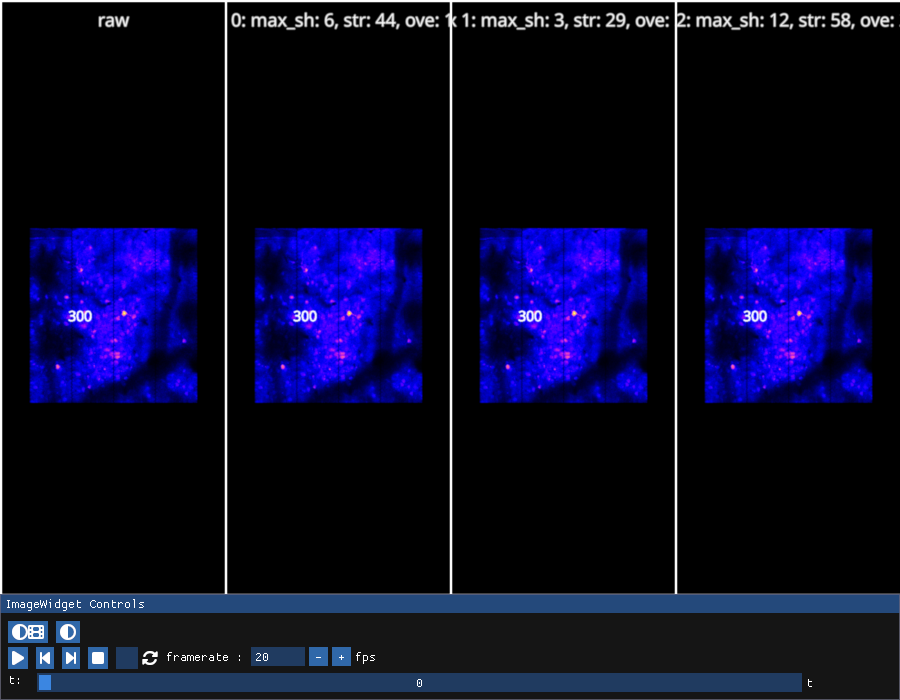

In [222]:
# Change the size/shape depending on how many parameter sweep inputs you used
figure_kwargs={"size": (900, 700), "shape": (1, len(movies))}

mcorr_iw_multiple = fpl.ImageWidget(
    data=movies,  # list of movies
    window_funcs={"t": (np.mean, 7)}, # window functions as a kwarg, this is what the slider was used for in the ready-made viz
    figure_kwargs=figure_kwargs,
    names=subplot_names,  # subplot names used for titles
    cmap="gnuplot2"
)

# free up some space
for subplot in mcorr_iw_multiple.figure:
    subplot.docks["right"].size = 0
    subplot.toolbar = False

mcorr_iw_multiple.show()

In [135]:
mcorr_iw_multiple.window_funcs["t"].window_size = 13

In [223]:
mcorr_iw_multiple.close()

# Apply the 'best parameters' to remaining files

When you decide which parameter set works the best, we keep it and delete the other batch items.

Remove batch items (i.e. rows) using `df.caiman.remove_item(<item_uuid>)`. This also cleans up the output data in the batch directory.

```{warning}
On windows, you will get an error `PermissionError: You do not have permissions to remove the output data for the batch item, aborting.` 

This can happen if you forgot to close one of the above widgets, or if you have a memory mapped file open.

There is currently no way to close a `numpy.memmap`: https://github.com/numpy/numpy/issues/13510

The solution is to restart your kernel. You will need to re-run the cells that define your batch/bath and reload your batch
with df = mc.load_batch(batch_path). Make sure `mc.set_raw_parent_data_path()` is in the re-run cells.
```

In [82]:
# UNCOMMENT THIS TO DELETE BATCH RUNS
# THIS IS COMMENTED OUT SO YOU DONT ACCIDENTALLY DELETE RESULTS YOU HAVE BEEN WAITING FOR ALL NIGHT!!!

# rows_keep = [2]
# for i, row in df.iterrows():
#     if i not in rows_keep:
#         df.caiman.remove_item(row.uuid, safe_removal=False)
# df

## Apply registration using the same parameters to the remaining files

In [ ]:
for i in range(len(tiff_files)):

    # don't re-process the same file
    if tiff_files[i].name == df.iloc[0].input_movie_path:
        continue

    df.caiman.add_item(
        algo='mcorr',
        input_movie_path=tiff_files[i],
        params= df.iloc[0].params,          # use the same parameters
        item_name=f'{tiff_files[i].name}',  # filename of the movie, but can be anything
    )

Processing: /home/flynn/caiman_data/out2/plane_21.tiff
Processing: /home/flynn/caiman_data/out2/plane_1.tiff
Processing: /home/flynn/caiman_data/out2/plane_16.tiff


In [83]:
df.caiman.reload_from_disk()
df

algo item_name input_movie_path  \
0  mcorr     mcorr     plane_1.tiff   
1  mcorr   plane_0    plane_21.tiff   
2  mcorr   plane_2    plane_16.tiff   

                                                                                                                    params  \
0  {'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...   
1  {'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...   
2  {'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...   

                                                                                                                   outputs  \
0  {'mean-projection-path': a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89_mean_projection.n...   
1                                                                                                                     None   
2                                                                                                                     None   

            added_time             ran_time algo_duration comments  \
0  2024-12-01T18:10:05  2024-12-01T18:13:10    170.19 sec     None   
1  2024-12-01T18:48:52                 None          None     None   
2  2024-12-01T18:48:52                 None          None     None   

                                   uuid  
0  a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89  
1  2918ff63-f204-4334-8837-ea172af89e39  
2  245bb955-feb9-4245-86bf-dd6ec1c79e95

In [84]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:06<00:00,  6.96s/it]


finished computing correlation image
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


finished computing correlation image
